# 模型评估与改进

In [1]:
#导入相关模块
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
%matplotlib inline

#忽略弹出的warnings
import warnings
warnings.filterwarnings('ignore')  
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## 交叉验证
### 评估模型泛化性能常用的统计方法

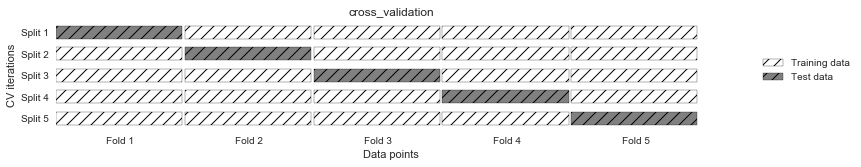

In [2]:
mglearn.plots.plot_cross_validation()

In [12]:
#交叉验证
from sklearn.model_selection import cross_val_score #交叉验证
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold 
kfold = KFold(n_splits=10) #可以通过kfold(交叉验证分离器)来控制cv参数

cancer = load_breast_cancer()
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf,cancer.data,cancer.target,cv=kfold) #cv是折数参数, 默认值为3
print("平均精度",scores.mean())

平均精度 0.957863408521


## 网络搜索 -- 通过调参提升模型泛化能力

### 简单的网络搜索

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  train_test_split
from sklearn.datasets import  load_breast_cancer

cancer = load_breast_cancer()
x_train,x_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0,test_size=0.3)

#对两种参数组合都训练一个rf模型
best_score = 0
for (max_depth,n_estimators) in [(x,y) for x in range(2,10) for y in range(20,100,10)]:
    rf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
    rf.fit(x_train,y_train)
    #在测试集上评估rf
    score = rf.score(x_test,y_test)
    #如果我们得到了更高得分数,则保存该分数下的参数
    if score > best_score:
        best_score = score
        best_parameters = {"n_estimators":n_estimators,"max_depth":max_depth}

print("最佳分数:",best_score)
print("最佳参数组:",best_parameters)

最佳分数: 0.982456140351
最佳参数组: {'n_estimators': 60, 'max_depth': 7}


### 带交叉验证的网络搜索

In [17]:
from sklearn.ensemble import RandomForestClassifier #随机森林分类器
from sklearn.model_selection import  train_test_split #数据集合拆分器
from sklearn.datasets import  load_breast_cancer #数据集
from sklearn.model_selection import cross_val_score #交叉验证
from sklearn.model_selection import KFold #k折交叉验证

cancer = load_breast_cancer()
x_train,x_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0,test_size=0.3)

#对两种参数组合都训练一个rf模型
best_score = 0
for (max_depth,n_estimators) in [(x,y) for x in range(2,10) for y in range(20,100,10)]:
    rf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
    #k折交叉验证
    kfold = KFold(n_splits=5)
    
    scores = cross_val_score(rf,cancer.data,cancer.target,cv=kfold)
    score = np.mean(scores)
    
    #如果我们得到了更高得分数,则保存该分数下的参数
    if score > best_score:
        best_score = score
        best_parameters = {"n_estimators":n_estimators,"max_depth":max_depth}

print("最佳分数:",best_score)
print("最佳参数组:",best_parameters)

最佳分数: 0.964881229623
最佳参数组: {'n_estimators': 50, 'max_depth': 6}


### 估计器 GridSearchCV方法---避免使用for循环,节约计算资源

In [18]:
from sklearn.ensemble import RandomForestClassifier #随机森林分类器
from sklearn.model_selection import  train_test_split #数据集合拆分器
from sklearn.datasets import  load_breast_cancer #数据集
from sklearn.model_selection import KFold #k折交叉验证
from sklearn.model_selection import GridSearchCV #估计器

cancer = load_breast_cancer()
x_train,x_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0,test_size=0.3)

#构建参数组集
param_grid ={"n_estimators": [x for x in range(20,100,10)],"max_depth":[y for y in range(2,10)]}

#构建网络搜索分类器
rf = RandomForestClassifier()
kfold = KFold(n_splits=5)
grid_search = GridSearchCV(rf,param_grid=param_grid, cv=kfold)

#进行交叉验证
grid_search.fit(x_train,y_train)

grid_search.score(x_test,y_test)

0.95906432748538006

In [21]:
#可视化参数组合结果
result = pd.DataFrame(grid_search.cv_results_)
result.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.03094,0.00189,0.93719,0.96671,2,20,"{'max_depth': 2, 'n_estimators': 20}",56,0.93750,0.96541,...,0.96250,0.96226,0.93671,0.96552,0.93671,0.96865,0.00372,0.00056,0.01586,0.00321
1,0.04721,0.00223,0.93970,0.96860,2,30,"{'max_depth': 2, 'n_estimators': 30}",52,0.97500,0.97170,...,0.92500,0.97170,0.93671,0.96552,0.96203,0.96552,0.01072,0.00031,0.02667,0.00276


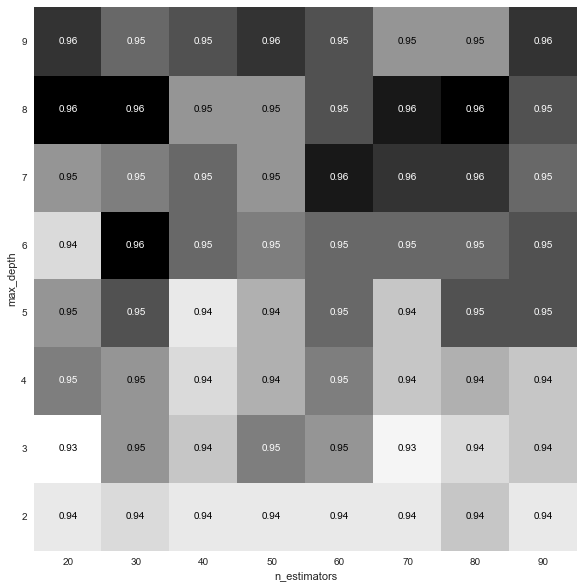

In [26]:
#各参数组合的scores
scores = np.array(result.mean_test_score).reshape(8,8)
plt.figure(figsize=(12,10))
mglearn.tools.heatmap(scores,xlabel="n_estimators",ylabel="max_depth",xticklabels=param_grid["n_estimators"],
                      yticklabels=param_grid["max_depth"])

## 评估指标与评分----混淆矩阵

[[ 60   3]
 [  4 104]]


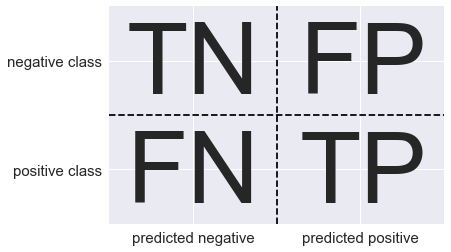

In [41]:

mglearn.plots.plot_binary_confusion_matrix()

##### 各项指标计算公式
###### 精度(accurary)
###### 所谓accuracy精度即是正确预测的数量(TN+TP)除以所有样本数(TN+FP+FN+TP):
\begin{equation}
\text{AUC} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\end{equation}

###### 准确率(Precision)
###### 准确率(precision)度量的是被预测为正例的样本中有多少时真正的正例
\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

###### 召回率(Recll)
###### 召回率(recall) 正样本中有多少被预测为正类
\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

###### F 综合度量值
\begin{equation}
\text{F} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
\end{equation}

In [44]:
from sklearn.ensemble import RandomForestClassifier #随机森林分类器
from sklearn.model_selection import  train_test_split #数据集合拆分器
from sklearn.datasets import  load_breast_cancer #数据集
from sklearn.model_selection import KFold #k折交叉验证
from sklearn.model_selection import GridSearchCV #估计器
from sklearn.metrics import confusion_matrix #混淆矩阵
from sklearn.metrics import classification_report #输出混淆矩阵各项指标
cancer = load_breast_cancer()
x_train,x_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0,test_size=0.3)

#构建参数组集
param_grid ={"n_estimators": [x for x in range(20,100,10)],"max_depth":[y for y in range(2,10)]}

#构建网络搜索分类器
rf = RandomForestClassifier()
kfold = KFold(n_splits=5)
grid_search = GridSearchCV(rf,param_grid=param_grid, cv=kfold)

#进行交叉验证训练
model = grid_search.fit(x_train,y_train)
print(model.score(x_test,y_test))

#输出混淆矩阵及各项指标
pred = model.predict(x_test)
confusion = confusion_matrix(y_test,pred)
print(confusion)

#输出准确率,召回率,f1值,数量
print(classification_report(y_test,pred,target_names = cancer.target_names))

0.970760233918
[[ 62   1]
 [  4 104]]
             precision    recall  f1-score   support

  malignant       0.94      0.98      0.96        63
     benign       0.99      0.96      0.98       108

avg / total       0.97      0.97      0.97       171



#### 准确率(precision)-召回率(recall)曲线

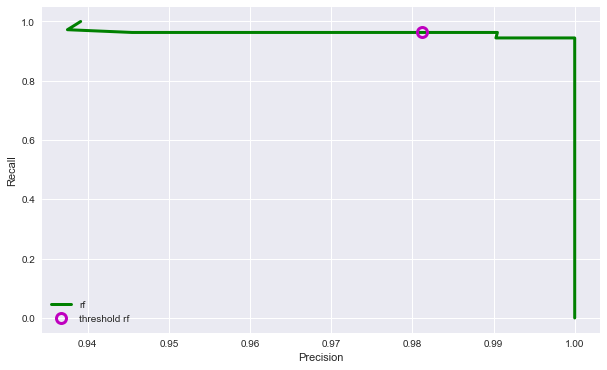

In [52]:
from sklearn.metrics import precision_recall_curve
precision,recall,thresholds = precision_recall_curve(y_test,model.predict_proba(x_test)[:,1]) #直接使用上文中的model
#找到最接近于0的阈值
close_zero = np.argmin(np.abs(thresholds-0.5))

plt.figure(figsize=(10,6))
plt.plot(precision,recall,label="rf",c="g",lw=3)
plt.plot(precision[close_zero],recall[close_zero],"o",c="m",markersize=10,label="threshold rf", fillstyle="none",mew=3)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

#### ROC与AUC,ROC即是受试者工作特征曲线,AUC表示ROC曲面下的面积大小,介于0~1之间

AUC分数: 0.995664315109


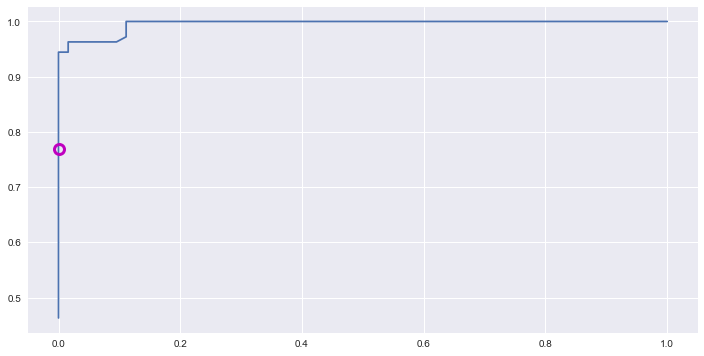

In [59]:
#导入ROC模块
from sklearn.metrics import roc_curve #ROC曲线
from sklearn.metrics import roc_auc_score #AUC分数

fpr_rf,tpr_rf,thresholds_rf = roc_curve(y_test,model.predict_proba(x_test)[:,1])

#找到最接近于0的阈值
close_zero = np.argmin(np.abs(thresholds-0.5))
plt.figure(figsize=(12,6))
plt.plot(fpr_rf,tpr_rf,label="ROC")
plt.plot(fpr_rf[close_zero],tpr_rf[close_zero],"o",markersize=10,label="threshold 0.5rf",fillstyle="none",c="m",mew=3)
#打印AUC分数
rf_auc = roc_auc_score(y_test,model.predict_proba(x_test)[:,1])
print("AUC分数:",rf_auc)